In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICES']='1'

import jax
import jax.numpy as jnp

import warnings
warnings.filterwarnings('ignore')

# import scienceplots
import matplotlib.pyplot as plt
import seaborn as sns

import sys 

sys.path.append("/home/nazar/projects/ott2/src")

from ott.neural.methods.flows.dynamics import ConstantNoiseFlow, LagrangianFlow
from lagrangian_ot import geometries, data, lagrangian_potentials
key = jax.random.PRNGKey(42)

In [2]:
DATASET = "lsb_box"

geometry_kwargs = {"spline_solver_kwargs":{
    "num_spline_nodes": 30,
    "grad_tol": 1e-5,
    "init_lr": 1e-3,
    "num_spline_points_eval": 20,
    "max_iter": 0}}
geometry = geometries.get(DATASET, geometry_kwargs)
source_sampler, target_sampler = data.get_samplers(DATASET, 128, key)
potential = lagrangian_potentials.BoxPotential()
params_potential = potential.init(key, jnp.ones((2, )))

In [3]:
xs = jnp.linspace(start=-1.5, stop=1.5, num=22)
xx, yy = jnp.meshgrid(xs, xs)
inp = jnp.vstack([xx.ravel(), yy.ravel()]).T


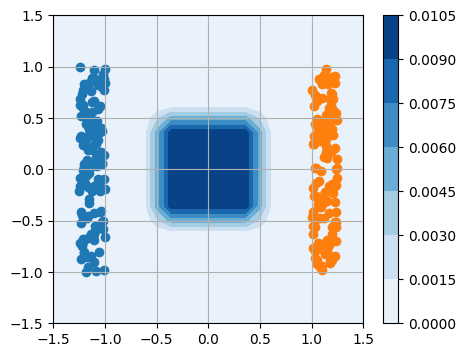

In [4]:
countours = jax.vmap(potential.apply, in_axes=(None, 0))(params_potential, inp)

fig, ax = plt.subplots(figsize=(5, 4))
source_data = next(source_sampler)
target_data = next(target_sampler)

plt.contourf(xx, yy, countours.reshape(xx.shape), cmap="Blues")
plt.colorbar()
ax.scatter(source_data[:, 0], source_data[:, 1])
ax.scatter(target_data[:, 0], target_data[:, 1])
plt.grid()
plt.show()

In [5]:
from functools import partial
import jax

class DatasetLoader:
    def __init__(self, size):
        self.size = size

    def __iter__(self):
        rng = jax.random.PRNGKey(42)
        while True:
            rng, sample_key = jax.random.split(rng, 2)
            yield DatasetLoader._sample(sample_key, self.size)

    @staticmethod
    @partial(jax.jit, static_argnums=(1,))
    def _sample(key, batch_size):
        k1, k2, key = jax.random.split(key, 3)
        x1 = jax.random.uniform(k1, (batch_size, 1), minval=-1.25, maxval=-1.0)
        x2 = jax.random.uniform(k2, (batch_size, 1), minval=-1.0, maxval=1.0)
        x_0 = jnp.concatenate([x1, x2], axis=1)
        
        k1, k2, key = jax.random.split(key, 3)
        x1 = jax.random.uniform(k1, (batch_size, 1), minval=1, maxval=1.25)
        x2 = jax.random.uniform(k2, (batch_size, 1), minval=-1.0, maxval=1.0)
        x_1 = jnp.concatenate([x1, x2], axis=1)

        return {
            "src_lin": x_0,
            "tgt_lin": x_1
        }

# NOCC

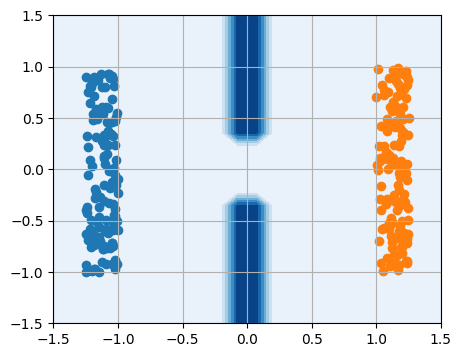

In [6]:
potential = lagrangian_potentials.SlitPotential()
params_potential = potential.init(key, jnp.ones((2, )))

countours = jax.vmap(potential.apply, in_axes=(None, 0))(params_potential, inp)

fig, ax = plt.subplots(figsize=(5, 4))
source_data = next(source_sampler)
target_data = next(target_sampler)

plt.contourf(xx, yy, countours.reshape(xx.shape), cmap="Blues")
ax.scatter(source_data[:, 0], source_data[:, 1])
ax.scatter(target_data[:, 0], target_data[:, 1])
plt.grid()
plt.show()

In [7]:
def draw_trajs(trajs, ax=None):
    # with plt.style.context(['science', 'notebook']):
    if ax is None:
        fig, ax = plt.subplots()
    colors = sns.color_palette("pastel", trajs.shape[1])
    
    for point in range(trajs.shape[1]):
        for t in range(1, trajs.shape[0]):
            ax.plot([trajs[t-1, point, 0], trajs[t, point, 0]],
                    [trajs[t-1, point, 1], trajs[t, point, 1]],
                    color=colors[point], linestyle="-", linewidth=1, marker='o', alpha=0.6, markersize=1)
    ax.grid(True)
    plt.show()

def callback(step, training_logs, transport):
    pi0 = next(data_loader)['src_lin']
    pi1 = next(data_loader)['tgt_lin']

    cost, trajs = transport(pi0)

    fig, ax = plt.subplots()
    countours = noc.flow.compute_potential(jnp.zeros_like(inp), inp) #jax.vmap(potential.apply, in_axes=(None, 0))(params_potential, inp)
    ax.contourf(xx, yy, countours.reshape(xx.shape), cmap="Blues")
    ax.scatter(pi0[:,0], pi0[:, 1], c='red', alpha=1, s=4)
    ax.scatter(pi1[:,0], pi1[:, 1], c='black', alpha=0.5, s=10)
    ax.scatter(trajs[-1].x[:, 0], trajs[-1].x[:, 1], c='green', s=10)
    ax.set_xlim((-1.5, 1.5))
    ax.set_ylim((-1.5, 1.5))
    draw_trajs(trajs=jnp.stack([traj.x for traj in trajs])[:, :100], ax=ax)
    plt.show()

  0%|          | 0/100000 [00:00<?, ?it/s]

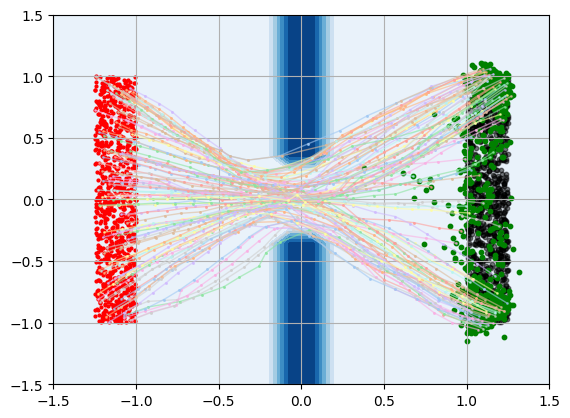

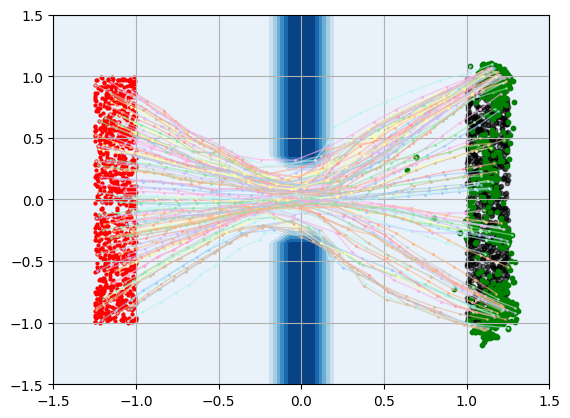

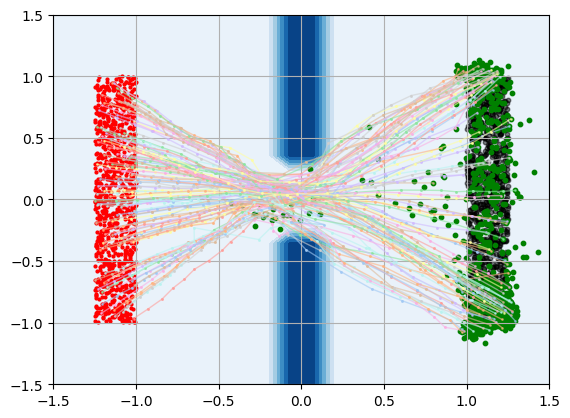

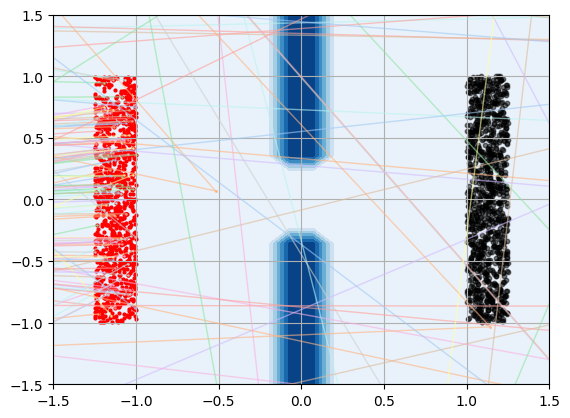

KeyboardInterrupt: 

In [8]:
from ott.neural.methods.flows.dynamics import ConstantNoiseFlow, LagrangianFlow, BrownianBridge
# from noc import NeuralOC
from ott.neural.methods.flows.nocc import  NeuralOC
import flax.linen as nn
import optax

    
class MLP(nn.Module):
    hidden_layers: list
    
    @nn.compact
    def __call__(self, t, x, _):
        x = jnp.concatenate([x, t, jnp.sin(10 * t), jnp.cos(10 * t)], -1)
        for i, dim in enumerate(self.hidden_layers):
            x = nn.Dense(dim)(x)
            if i != len(self.hidden_layers) - 1:
                x = nn.leaky_relu(x)
        return x

key = jax.random.PRNGKey(42)  
net = MLP(hidden_layers=[256, 256, 256, 256, 1])
num_iterations = 100_000
lr_schedule = optax.cosine_decay_schedule(
    init_value=1e-4, decay_steps=num_iterations, alpha=1e-2
)
noc = NeuralOC(input_dim=2, value_model=net, optimizer=optax.adam(learning_rate=lr_schedule, b1=0.9, b2=0.99), potential_weight=30, flow=LagrangianFlow(sigma=0.05, potential=lagrangian_potentials.SlitPotential()), key=key)
data_loader = iter(DatasetLoader(1024))

logs = noc(data_loader, n_iters=num_iterations, rng=key, callback=callback)